In [21]:
import os # funadamental library for handling
from statistics import mode # calculate mode on `object`
from tqdm import tqdm as TQ # library for displaying progress bar

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline
sns.set_style('whitegrid');
plt.style.use('default-style'); # https://gitlab.com/ZenithClown/computer-configurations-and-setups
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 15)
np.set_printoptions(precision = 3, threshold = 15)
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
ROOT = "." # the document root is one level up, that contains all code structure
DATA = os.path.join(ROOT, "dataset") # the directory contains all data files, subdirectory (if any) can also be used/defined

In [2]:
def read_file(filepath : str) -> pd.DataFrame:
    """
    Read the given `csv` file as provided during for the competition. There
    are three files `train`, `test` and `sample_submission` representing the
    training, testing and sample submission file. All the files are as per
    general convention.
    
    The function reads a particular file, pre-process some of the sections and
    finally returns a processed dataframe.
    """
    
    data = pd.read_csv(filepath, index_col = "Property_ID")
    return data.copy() # deep copy the frame

In [5]:
train, test, _ = [read_file(os.path.join(DATA, f"{filename}.csv")) for filename in TQ(["train", "test", "sample_submission"])]

# print additional infos about the file
print(train.shape, test.shape)
print("Prediction Columns : ", [cols for cols in train.columns if cols not in test.columns])

# print memory usage, later apply optimization techniques
print(f"Memory Usage : {train.memory_usage(deep = True).sum() / 1024 ** 2:.2f} MB")

train.sample(5) # display sample records

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.42it/s]

(39499, 14) (10500, 13)
Prediction Columns :  ['Habitability_score']
Memory Usage : 20.11 MB


,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
Property_ID,,,,,,,,,,,,,,
0x83c1,Bungalow,2563,15.00,4,Semi_Furnished,1.00,No,Once in a day - Morning,6.96,Slightly below average,Medium,125.00,3.18,75.69
0x3fbf,Apartment,817,4.00,2,Semi_Furnished,1.00,No,Once in a day - Morning,8.04,Well below average,High,157.00,3.70,65.13
0xbc65,Bungalow,2878,7.00,5,Unfurnished,0.00,Yes,Once in a day - Morning,7.72,Well below average,Medium,105.00,4.46,74.28
0x92e5,Single-family home,2169,5.00,4,Unfurnished,0.00,No,Once in a day - Evening,6.82,Well below average,Medium,126.00,4.12,71.62
0x59f5,Single-family home,1939,3.00,3,Semi_Furnished,1.00,No,Once in two days,4.13,Slightly below average,Medium,80.00,2.63,69.10


In [16]:
test["type"] = "test"
train["type"] = "train"

In [17]:
train.shape, test.shape

((39499, 15), (10500, 14))

In [41]:
total = pd.concat([train, test], axis = 0) # concat total data, for na analysis
total.shape, total[total["type"] == "train"].shape

((49999, 15), (39499, 15))

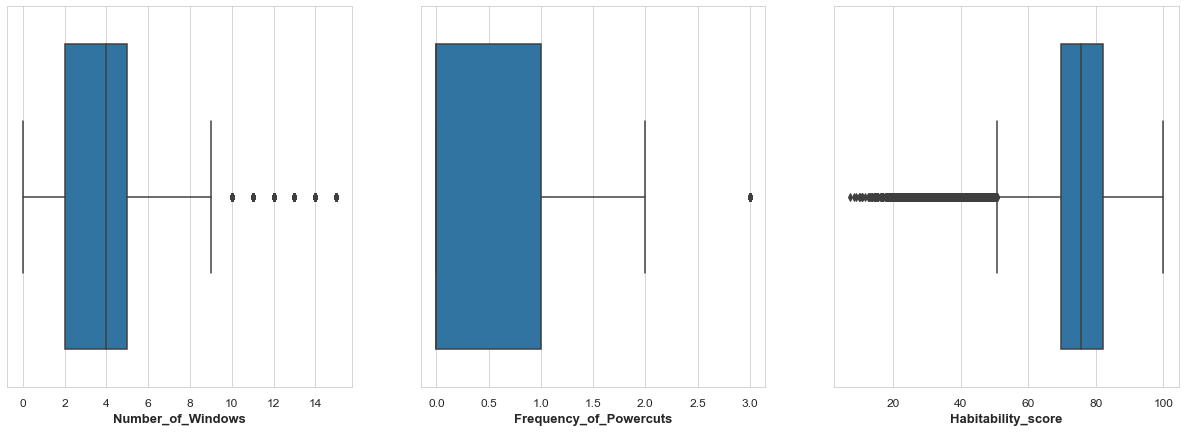

In [33]:
columns = [col for col in total.columns if (total[col].dtype != object) and (total[col].isnull().sum() > 0)]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

for col, axs in zip(columns, (ax1, ax2, ax3)):
    sns.boxplot(x = col, data = train, ax = axs)

In [42]:
missing_value = dict()
for col in total.columns:
    print(f"Missing Value Analysis : {col}")
    
    if total[col].isnull().sum() > 0:
        if total[col].dtype == object:
            # calculate mode on the same, and append the value
            missing_value[col] = mode(total[~total[col].isnull()][col].values)
        else:
            missing_value[col] = total[col].mean()
    else:
        print(" >> No Values NULL.")
        
missing_value

Missing Value Analysis : Property_Type
 >> No Values NULL.
Missing Value Analysis : Property_Area
 >> No Values NULL.
Missing Value Analysis : Number_of_Windows
Missing Value Analysis : Number_of_Doors
 >> No Values NULL.
Missing Value Analysis : Furnishing
Missing Value Analysis : Frequency_of_Powercuts
Missing Value Analysis : Power_Backup
 >> No Values NULL.
Missing Value Analysis : Water_Supply
 >> No Values NULL.
Missing Value Analysis : Traffic_Density_Score
 >> No Values NULL.
Missing Value Analysis : Crime_Rate
Missing Value Analysis : Dust_and_Noise
Missing Value Analysis : Air_Quality_Index
 >> No Values NULL.
Missing Value Analysis : Neighborhood_Review
 >> No Values NULL.
Missing Value Analysis : Habitability_score
Missing Value Analysis : type
 >> No Values NULL.


{'Number_of_Windows': 3.918,
 'Furnishing': 'Semi_Furnished',
 'Frequency_of_Powercuts': 0.485,
 'Crime_Rate': 'Well below average',
 'Dust_and_Noise': 'Medium',
 'Habitability_score': 73.482}

In [43]:
total.fillna(missing_value, inplace = True)

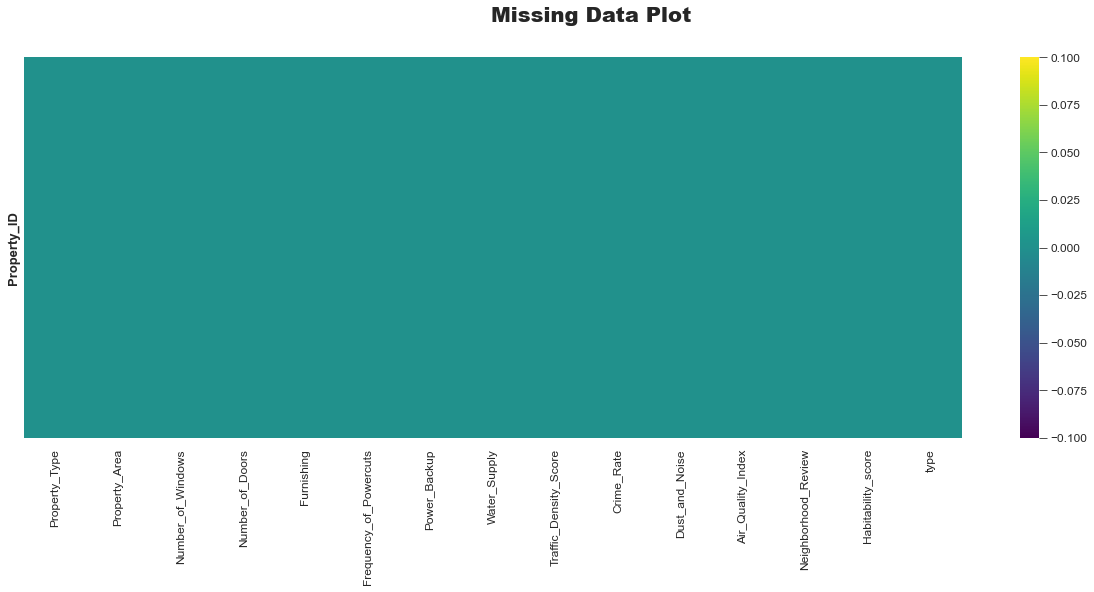

In [44]:
sns.heatmap(total.isnull(), cmap = "viridis", yticklabels = False)

plt.suptitle("Missing Data Plot")
plt.show()

In [48]:
total.to_excel("./dataset/total.xlsx", sheet_name = "no null") # total data for analysis